In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt

from utils.preprocess import load_tof, Phi
from utils.plot import plot_predictions, make_palette
from image_processing import process

from models.mixture import MixIRLS

In [2]:
def add_bias(X):
    return np.c_[np.ones(len(X)), X]


In [3]:
FILE_PATH = '../data/tof_erda/raw/I_36MeV_SH2-1_TiN-ref.lst'
X, y, phi = load_tof(FILE_PATH)
X, y = process(X,y, noise_sensitivity=0.9)
phi = Phi(X)
data = np.vstack([X,y,phi.flatten()]).T
data = np.unique(data, axis=0)
X, y, phi = data[:,0], data[:,1], data[:,2]

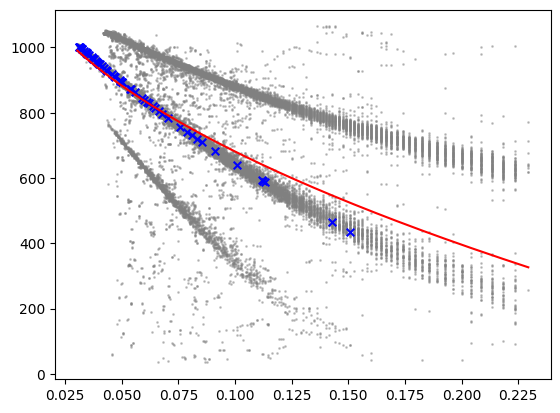

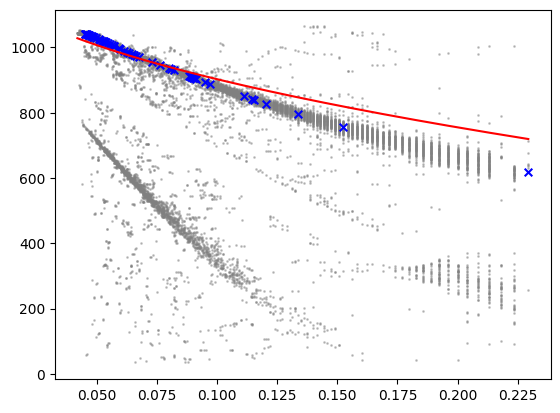

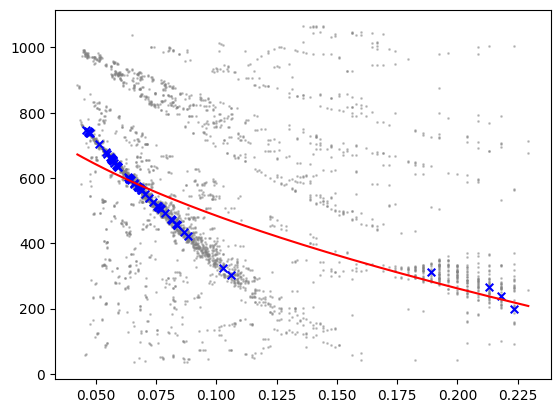

[[ 1370.16738446  1258.28247682  1022.09824275]
 [   -0.            -0.            -0.        ]
 [   -0.            -0.            -0.        ]
 [-2179.04695048 -1125.2261193  -1699.72365657]
 [   -0.            -0.            -0.        ]
 [   -0.            -0.            -0.        ]
 [   -0.            -0.            -0.        ]
 [   -0.            -0.            -0.        ]
 [   -0.            -0.            -0.        ]
 [   -0.            -0.            -0.        ]
 [   -0.            -0.            -0.        ]
 [   -0.            -0.            -0.        ]
 [   -0.            -0.            -0.        ]
 [   -0.            -0.            -0.        ]
 [   -0.            -0.            -0.        ]
 [   -0.            -0.            -0.        ]
 [   -0.            -0.            -0.        ]
 [   -0.             0.            -0.        ]
 [    0.             0.            -0.        ]
 [    0.             0.             0.        ]
 [    0.             0.             0.  

In [4]:
K = 3
wfun = lambda r: 1 / (1+r**2)
plot = True
alpha = 1

model = MixIRLS(K=K, wfun=wfun, plot=plot, alpha=alpha)

exponents = [-1/i for i in range(2, 30)]
phi = Phi(X, exponents)

sprim, supports, iter = model.train(phi, y)
y_pred = model.predict(phi)
print(model.beta)

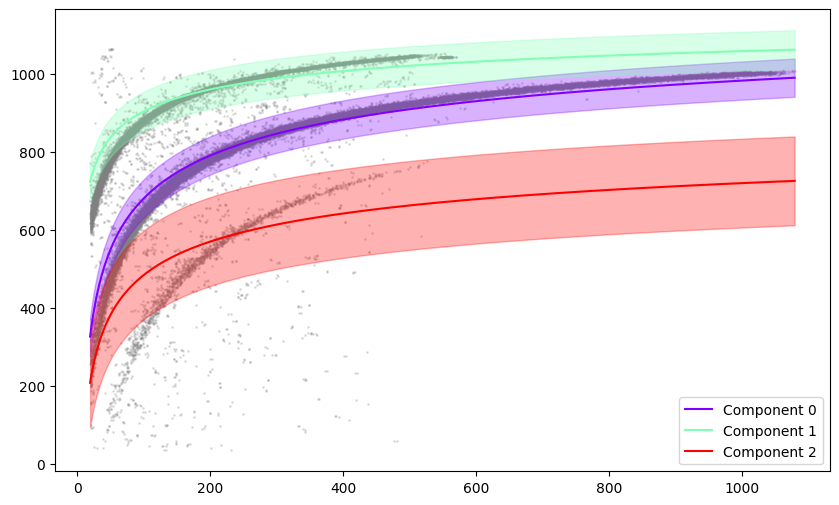

Points in support for component 0:  28779
  Number of points in component 0:  58


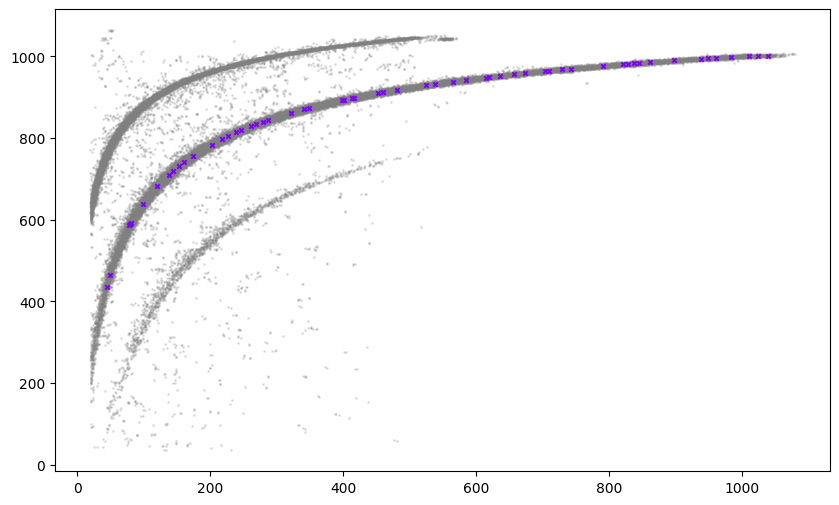

Points in support for component 1:  10999
  Number of points in component 1:  58


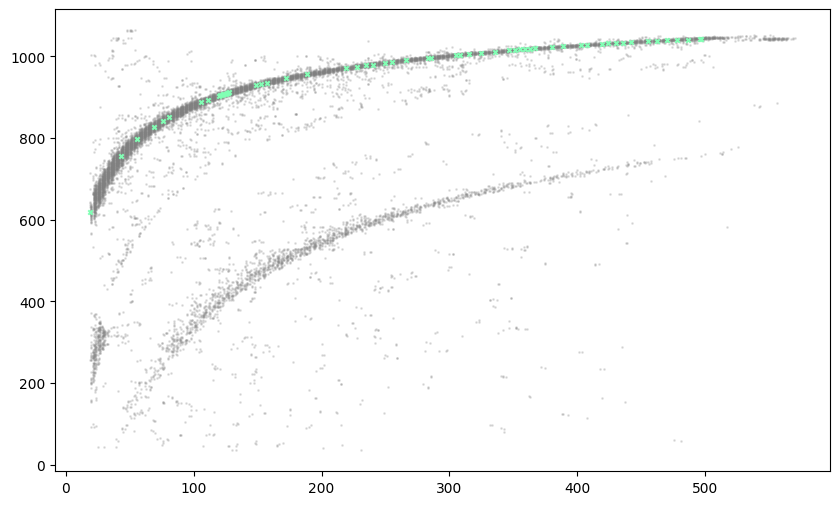

Points in support for component 2:  3456
  Number of points in component 2:  58


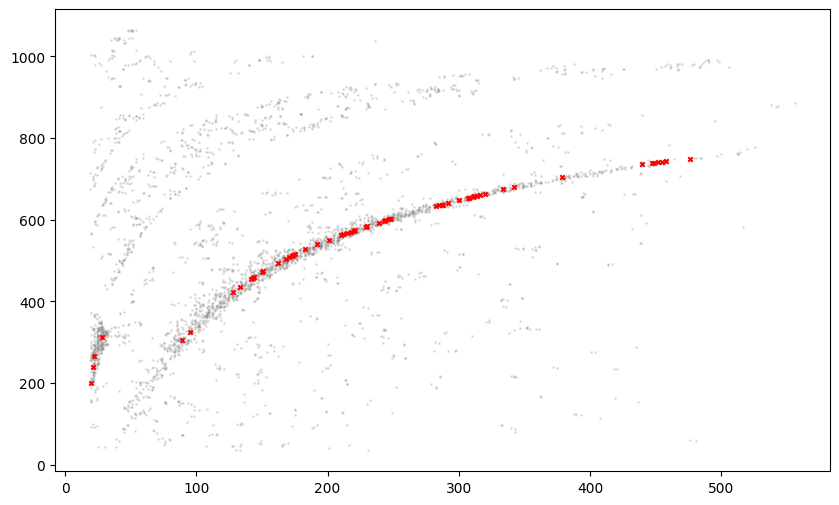

In [6]:
colors = make_palette(K)
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.2, color='grey', s=1)
for k in range(K):
    i = sprim[k]
    # Plot component points
    #plt.scatter(X[i], y[i], alpha=0.3, color=colors[k], s=1, label=f"Component {s}")
    
    # Sort based on X values but keep track of indices
    sort_idx = np.argsort(X)
    
    PHI = Phi(X[sort_idx], exponents)
    pred = model.predict_k(PHI, k)
    # Plot prediction line against sorted X[sort_idx]
    plt.plot(X[sort_idx], pred, color=colors[k], label=f"Component {k}")
    plt.fill_between(X[sort_idx], 
                            pred - 2*np.sqrt(model.sigma[k]), 
                            pred + 2*np.sqrt(model.sigma[k]), 
                            color=colors[k],
                            alpha=0.3)
    
plt.legend()
plt.show()


for k in range(K):
    
    i = supports[:,k] # points that were considered
    j = sprim[k] # points that were trained on, relative to support
    sort_idx = np.argsort(X[i])

    print(f"Points in support for component {k}: ", i.sum())
    print(f"  Number of points in component {k}: ", len(X[i][j]))
    
    plt.figure(figsize=(10, 6))
    plt.scatter(X[i], y[i], alpha=0.2, s=1, color='grey')
    plt.scatter(X[i][j], y[i][j], alpha=1, s=10, marker='x',  color=colors[k])

    # Calculate predictions using sorted phi
    #PHI = add_bias(Phi(X[i][sort_idx], exponents))
    #PRED = model.predict_k(PHI, k)
    
    # Plot prediction line against sorted X
    #plt.plot(PHI[i][sort_idx], PRED, color=colors[s], label=f"Component {s}")
    #plt.fill_between(X[i][sort_idx], 
    #                        PRED - 2*np.sqrt(sigma[s]), 
    #                        PRED + 2*np.sqrt(sigma[s]), 
    #                        color=colors[s],
    #                        alpha=0.3)
    plt.show()